<div style="text-align:center">
    <h1>Retrograde stars</h1>
    <p style="text-align:center">Find details about the retrograde stars for Carrie</p>
</div>

In [1]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("default")


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load the population
Let's just use the fiducial model

Important details for Carrie:
 - Follows FIRE m11h (disc-like dwarf galaxy)
 - ~2.2 million systems evolved
 - 0.5 binary fraction, $m_1 > 4$
 - All star particles from last 150 Myr evolved until present day **+ 200 Myr** <-- probably reduces the rates
 
 
Ideal results should probably use one of the more massive FIRE galaxies (closer to MW?) and only evolve until present days so more stars are still alive.

In [3]:
p = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/supernovae/vir_1.0-ce_1.0")

In [5]:
from importlib import reload
import sys
sys.path.append("../src")
import plotting

In [409]:
reload(plotting)
plotting.set_sn_subpop_masks(p);

17068 247674 159305 313495


In [7]:
f = np.load(f"/mnt/home/twagg/ceph/pops/supernovae/sn_positions-vir_1.0-ce_1.0.npz")
p.primary_sn_distances, p.secondary_sn_distances = f["arr_0"] * u.kpc, f["arr_1"] * u.kpc

# Identify retrograde orbits

In [11]:
p.final_pos

<Quantity [[-2.88585724e+00,  7.58379175e+00,  8.52753236e-02],
           [-3.45147201e-01,  9.31741319e+00,  3.18646238e+00],
           [-2.14692567e+01,  7.09300937e+00,  1.30878477e+00],
           ...,
           [-9.99870096e+00, -9.42860556e+01,  5.12621396e+01],
           [-4.21198909e+01,  1.29663730e+01, -6.57753959e+01],
           [ 6.19741777e+00, -1.43655636e+01,  2.41134845e+00]] kpc>

In [13]:
from astropy.coordinates import SkyCoord

In [31]:
c = SkyCoord(x=p.final_pos[0][0], y=p.final_pos[0][1], z=p.final_pos[0][2],
         v_x=p.final_vel[0][0], v_y=p.final_vel[0][1], v_z=p.final_vel[0][2], frame="galactocentric", representation_type="cartesian").represent_as("cylindrical")
c

<CylindricalRepresentation (rho, phi, z) in (kpc, rad, kpc)
    (8.11431262, 1.93440603, 0.08527532)
 (has differentials w.r.t.: 's')>

In [40]:
def vphi(pos, vel):
    x, y, vx, vy = pos[:, 0], pos[:, 1], vel[:, 0], vel[:, 1]
    return (x * vy - vx * y) / (x**2 + y**2)

In [43]:
retrograde = vphi(p.final_pos, p.final_vel) < 0

In [78]:
retrograde.sum() / len(retrograde)

0.16396096821879788

## Work out which retrograde binaries actually have stars
And convert that to a population

**Assuming you don't want white dwarfs (or NS/BH haha)**

In [81]:
bound_retrograde = p.bin_nums[~p.disrupted & retrograde[:len(p)]]
disrupted_retrograde_1 = p.bin_nums[p.disrupted & retrograde[:len(p)]]
disrupted_retrograde_2 = p.bin_nums[p.disrupted][retrograde[len(p):]]

In [104]:
len(bound_retrograde)

268796

In [105]:
len(disrupted_retrograde_1)

68851

In [106]:
len(disrupted_retrograde_2)

53657

In [139]:
R_KS_LIMIT = 10

retrograde_stars = []
x = p.final_bpp.loc[bound_retrograde]
retrograde_stars = np.concatenate((retrograde_stars, x[(x['kstar_1'] < R_KS_LIMIT) | (x['kstar_2'] < R_KS_LIMIT)]["bin_num"].values))
print(len(retrograde_stars))

x = p.final_bpp.loc[disrupted_retrograde_1]
retrograde_stars = np.concatenate((retrograde_stars, x[(x['kstar_1'] < R_KS_LIMIT)]["bin_num"].values))
print(len(retrograde_stars))

x = p.final_bpp.loc[disrupted_retrograde_2]
retrograde_stars = np.concatenate((retrograde_stars, x[(x['kstar_2'] < R_KS_LIMIT)]["bin_num"].values))
retrograde_stars = retrograde_stars.astype(int)
print(len(retrograde_stars))

1481
1481
4035


In [424]:
%%time
rp_basic = p[retrograde_stars]

CPU times: user 8 s, sys: 981 ms, total: 8.98 s
Wall time: 8.98 s


### Quick fix: some of the star particle started retrograde

In [369]:
star_particles = pd.read_hdf("../data/FIRE_star_particles.h5")

In [392]:
weird_particles = vphi(star_particles[["x", "y"]].values, star_particles[["v_x", "v_y"]].values) < 0

In [396]:
wp_ids = star_particles[weird_particles].index.values

In [425]:
rp = rp_basic[rp_basic.bin_nums[~rp_basic.initC["particle_id"].isin(wp_ids)]]

# Characteristics

## Metallicity
<!-- Trends to slightly higher than the input distribution, likely just because I'm only selecting **present day** retrograde stars and so it skews to recent star formation = high Z -->

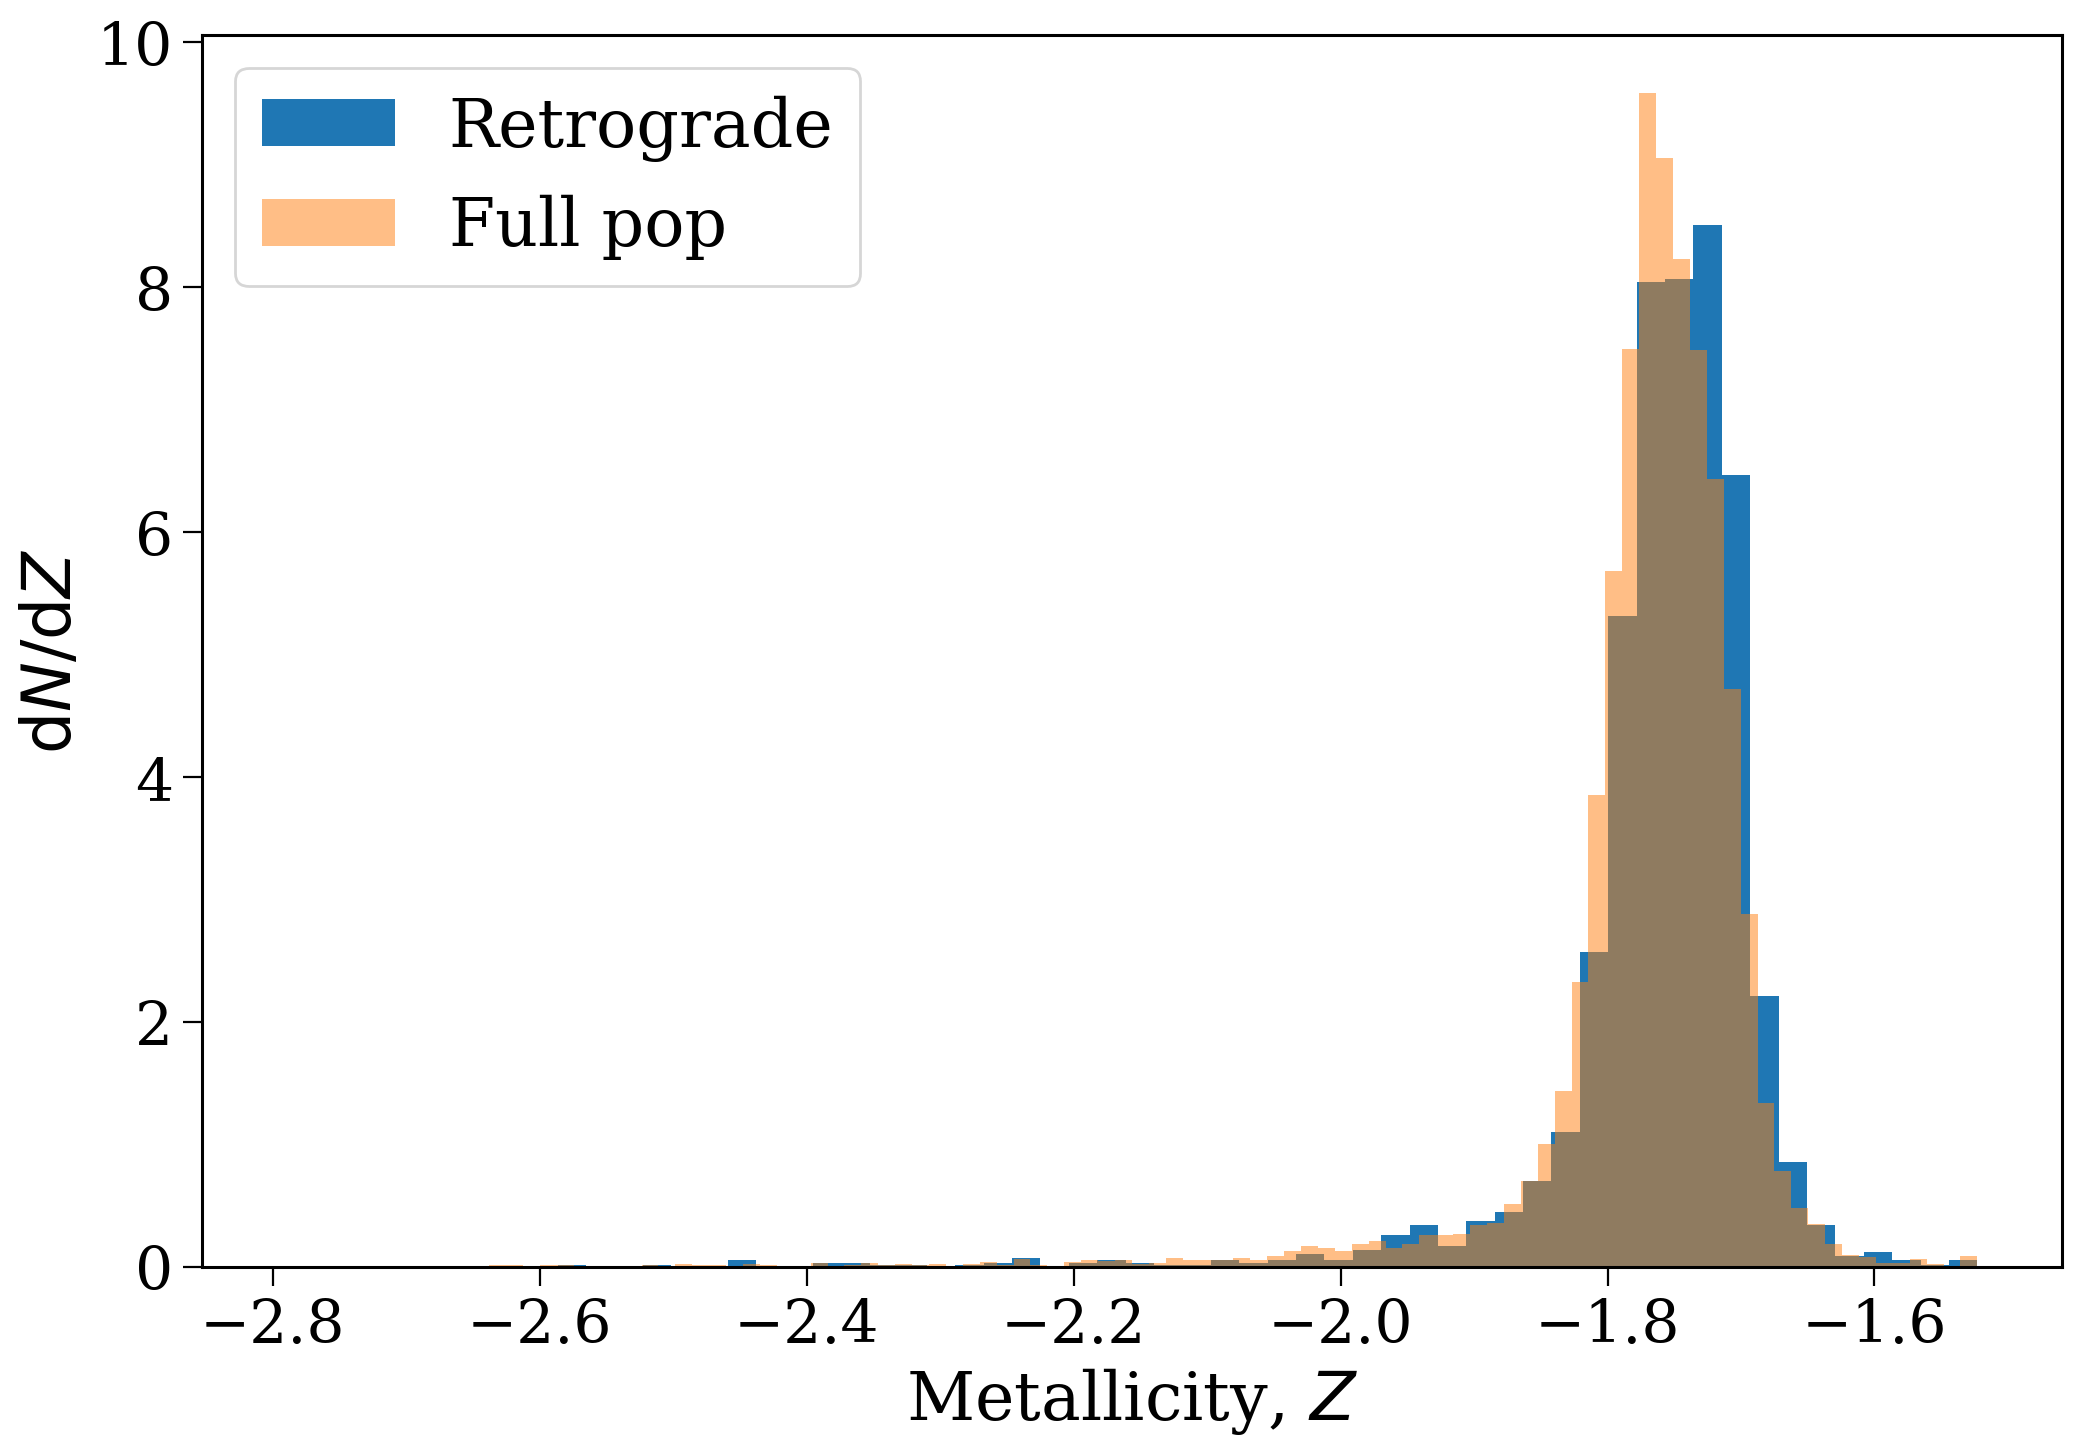

In [427]:
fig, ax = plt.subplots()

ax.hist(np.log10(rp.initial_galaxy.Z), bins=50, density=True, label="Retrograde")
ax.hist(np.log10(p.initial_galaxy.Z), bins=100, density=True, alpha=0.5, label="Full pop")

ax.legend()
ax.set(xlabel=r"Metallicity, $Z$", ylabel=r"$\mathrm{d}N/\mathrm{d}Z$")

plt.show()

## Galactic radius

In [428]:
def mask_dis_1(thing):
    return np.concatenate((thing[:len(rp)][~rp.disrupted], thing[len(rp):]))

In [429]:
final_pos = mask_dis_1(rp.final_pos)

In [430]:
R = (final_pos[:, :2]**2).sum(axis=1)**(0.5)

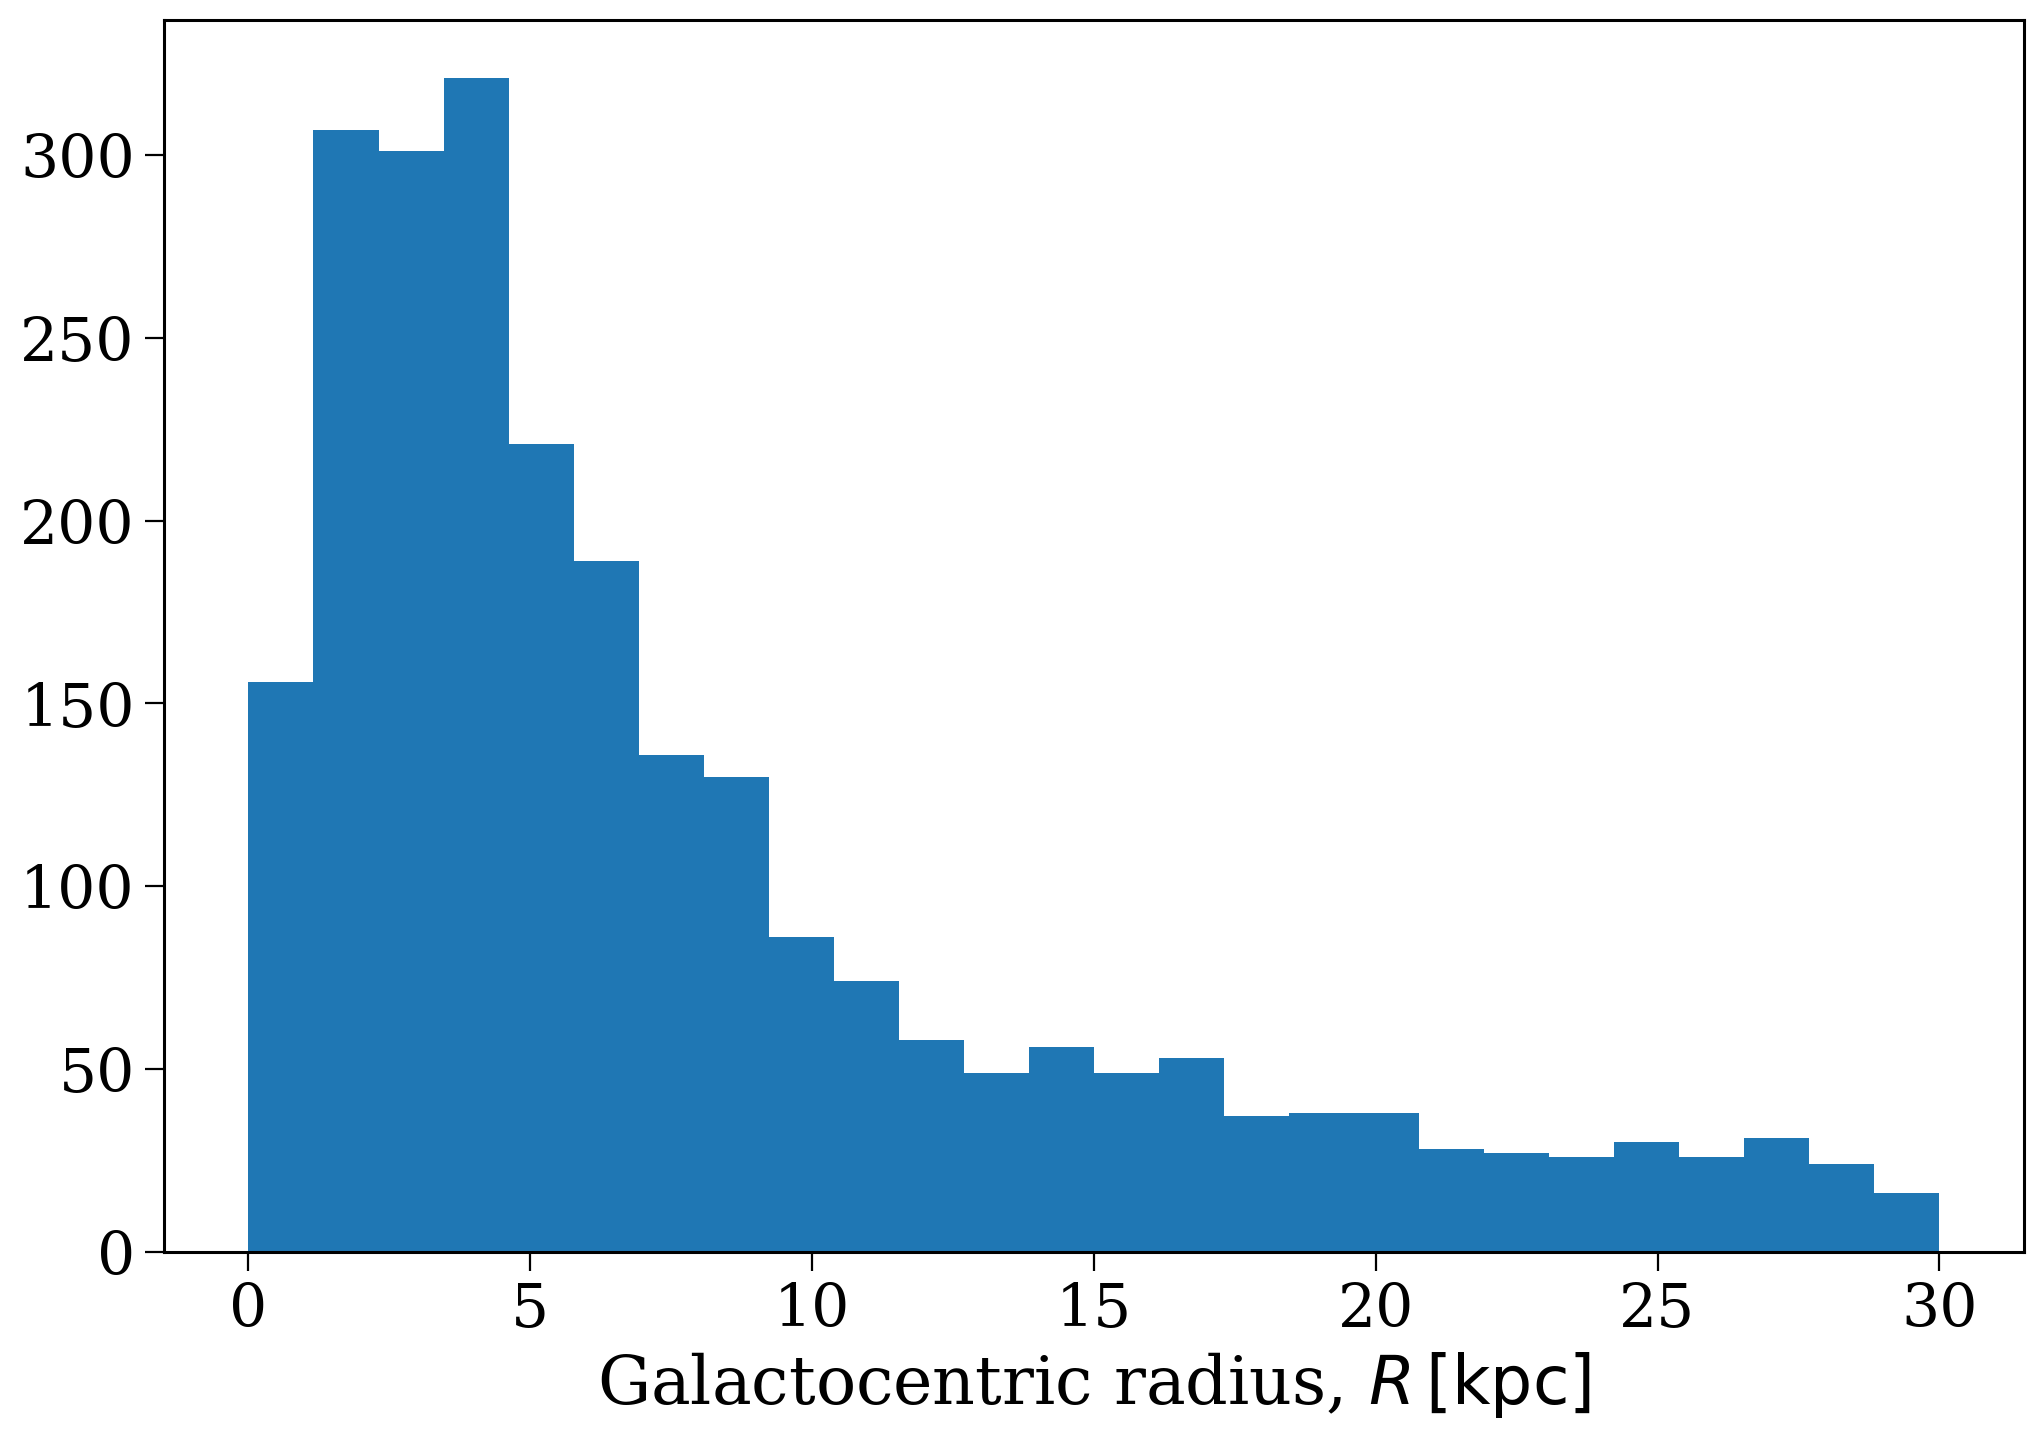

In [431]:
plt.hist(R.value, bins="fd", range=(0, 30));
plt.xlabel(r"Galactocentric radius, $R \, {\rm [kpc]}$")
plt.show()

### Relative to birth

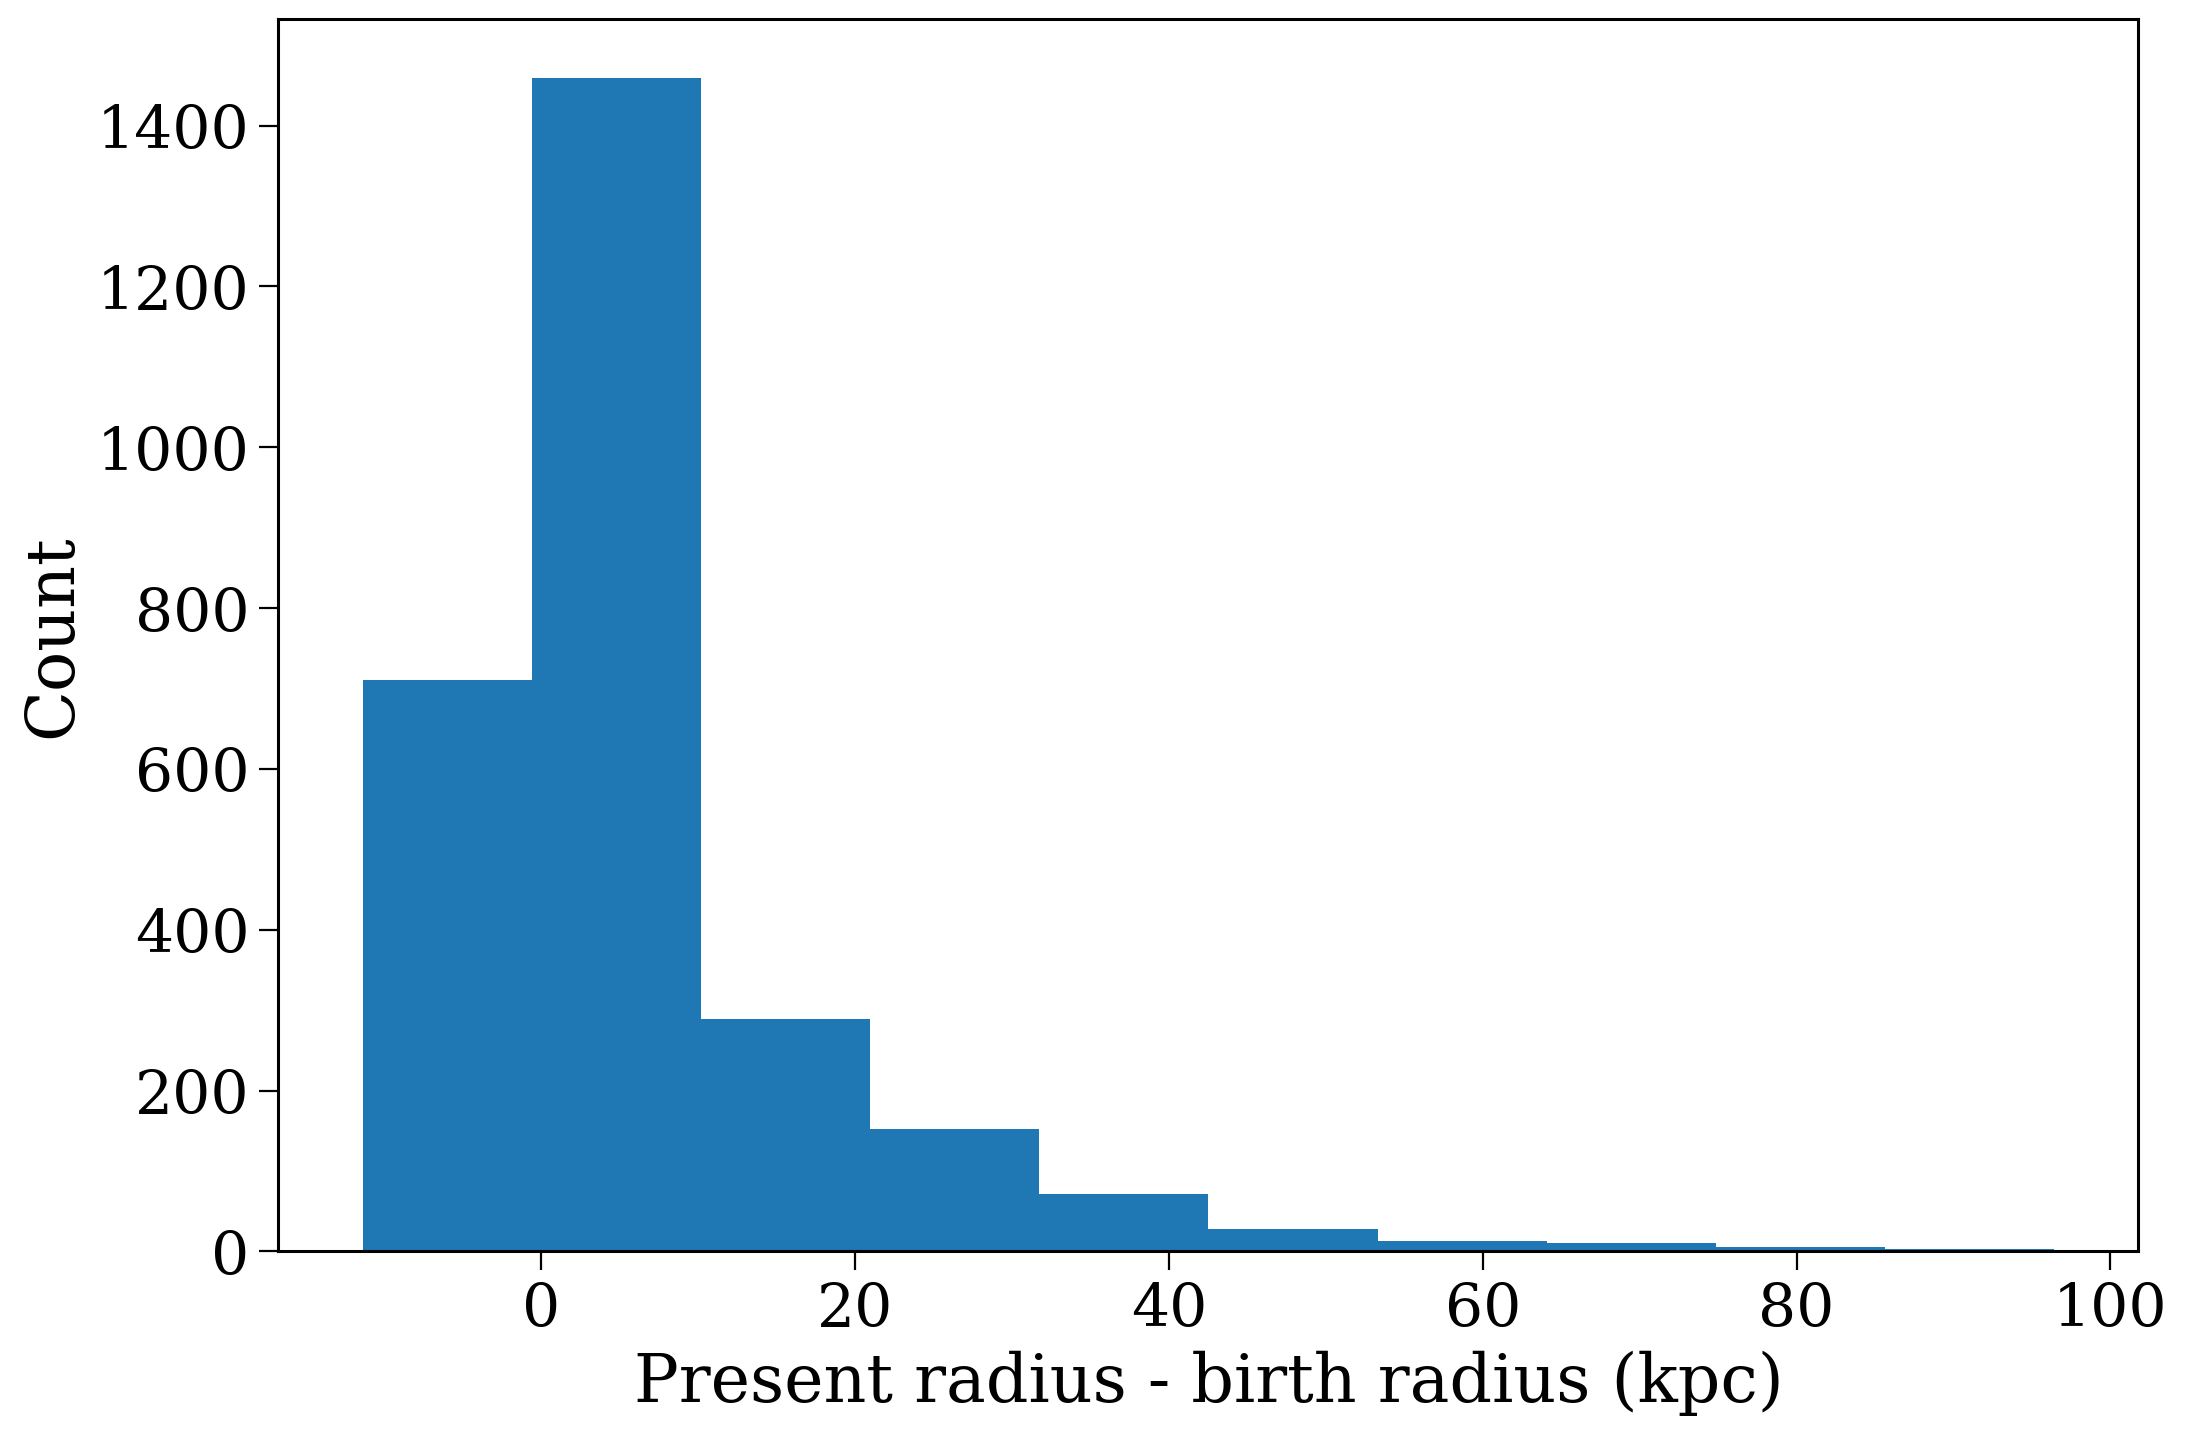

In [432]:
fig, ax = plt.subplots()

plt.hist(R - rp.initial_galaxy.rho)

ax.set(xlabel=r"Present radius - birth radius (kpc)", ylabel="Count")

plt.show()

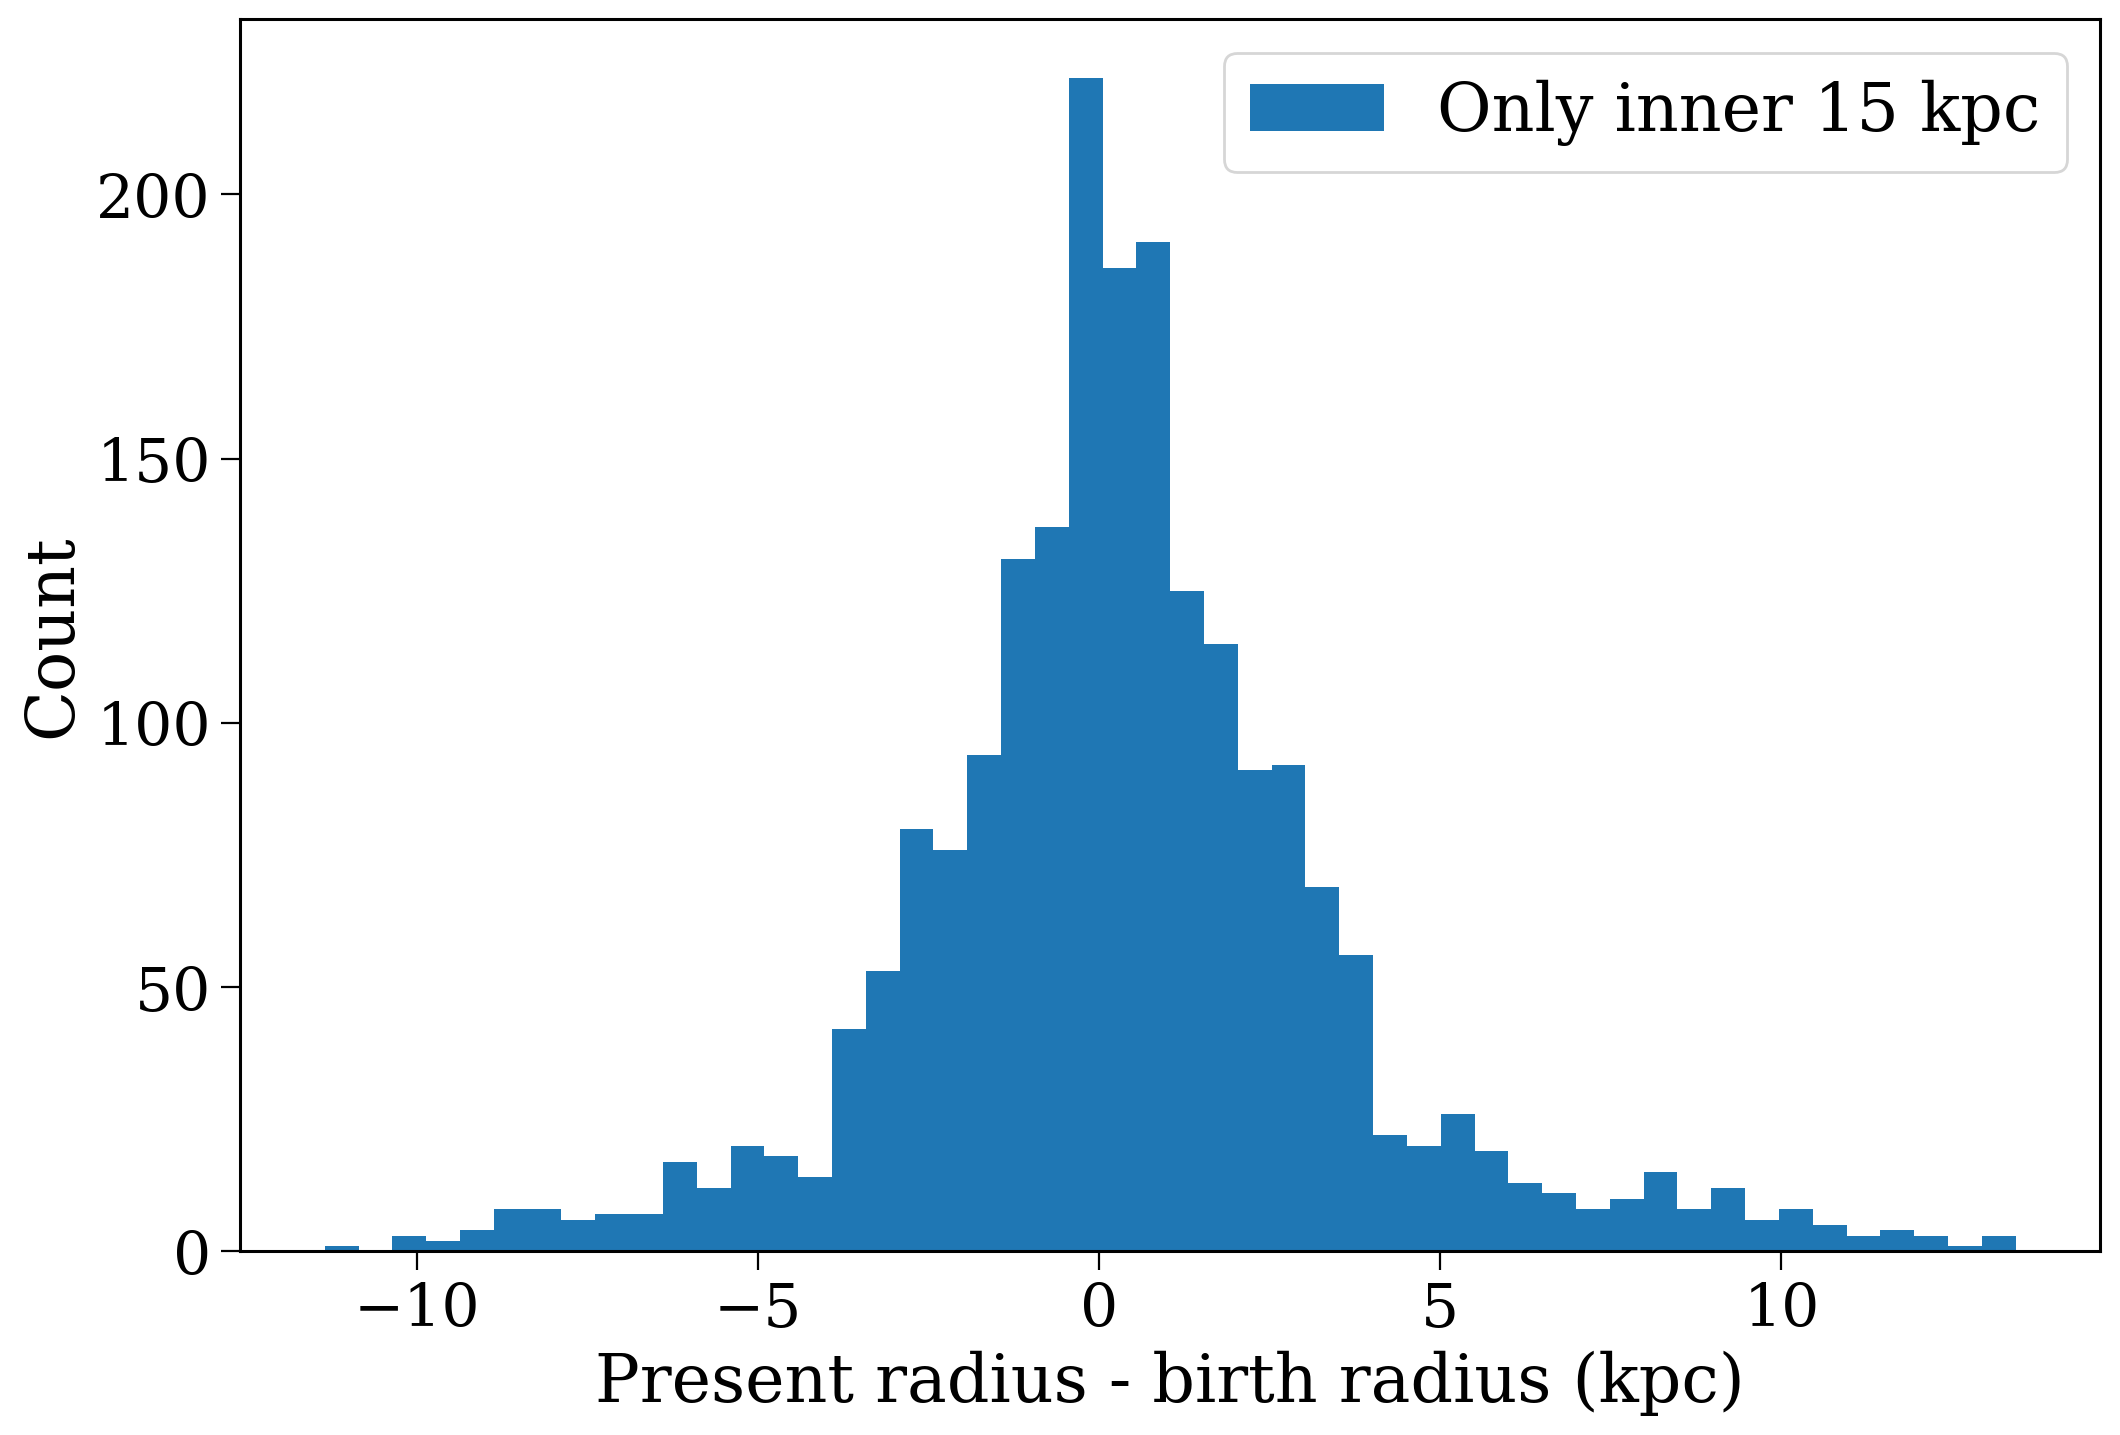

In [433]:
fig, ax = plt.subplots()

ax.hist((R - rp.initial_galaxy.rho)[R < 15 * u.kpc], bins=50, label="Only inner 15 kpc")

ax.set(xlabel=r"Present radius - birth radius (kpc)", ylabel="Count")

ax.legend()

plt.show()

# Check the masses

In [454]:
rp.final_bpp

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num,metallicity
2549,311.298736,1.242000,2.684297,13.0,1.0,9.382291,1.680908,0.224553,0.000006,0.854347,10.0,288.732804,307.913004,1.000000e+10,524.331845,1.242000,0.0,0.000014,2.777892,1.412176,2.684297,2.773954e-07,68.206913,35561.526526,9996.985478,0.000014,0.0,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,3.416366e+06,1753.089103,1.673902e+13,0.0,0.000000,0.0,0.000000,0.0,22.565932,3.385732,0.0,0.0,2549,0.017250
72134,202.280780,1.277584,1.788727,13.0,1.0,44.136002,19.406784,0.735220,0.000003,0.344750,10.0,171.556081,201.085394,1.000000e+10,1660.308487,1.277584,0.0,0.000014,1.645229,2.591969,1.788727,8.007530e-07,10.111020,46353.255610,8060.374461,0.000014,0.0,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,2.015789e+06,1664.938929,3.713825e+13,0.0,0.000000,0.0,0.000000,0.0,30.724699,1.195386,0.0,0.0,72134,0.016313
86513,237.144234,1.442110,1.022322,13.0,1.0,2.514854,0.294431,0.000000,0.000014,1.035531,10.0,216.456514,273.987854,1.000000e+10,11200.805703,1.442110,0.0,0.000014,0.910317,2.400292,1.022322,5.455287e-07,0.712227,42112.399494,5582.488548,0.000014,0.0,1.000000e-10,3.035064e-02,1.000000e-10,2.318565e-01,2.396816e+11,7734.274604,2.208071e+08,0.0,0.164526,0.0,216.456514,0.0,20.687719,-36.843621,0.0,0.0,86513,0.020129
88404,335.688031,1.521928,1.079530,13.0,1.0,2.724760,0.323189,0.000000,0.000013,1.031659,10.0,322.366730,465.893096,1.000000e+10,9002.889076,1.521928,0.0,0.000014,0.982747,3.426642,1.079530,2.549961e-07,0.951083,34820.820308,5775.682810,0.000014,0.0,1.000000e-10,2.361135e-02,1.000000e-10,2.320322e-01,3.420462e+11,7059.130904,5.682153e+07,0.0,0.244344,0.0,322.366730,0.0,13.321301,-130.205065,0.0,0.0,88404,0.019350
94327,315.443614,1.768411,0.530028,13.0,0.0,1.649107,0.161893,0.000000,0.000017,1.053223,10.0,279.193478,939.626949,1.000000e+10,115030.622629,1.768411,0.0,0.000014,0.487995,1.419664,0.530028,3.759241e-07,0.042700,38369.014172,3772.842107,0.000014,0.0,1.000000e-10,1.298121e-01,1.000000e-10,1.839349e-01,5.021278e+11,14083.007298,5.624522e+07,0.0,0.526411,0.0,279.193478,0.0,36.250137,-624.183335,0.0,0.0,94327,0.018887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155284,256.302620,1.277584,3.075180,13.0,1.0,-1.000000,-1.000000,-1.000000,0.000100,0.000100,10.0,220.438835,256.298194,1.000000e+10,371.170763,1.277584,0.0,0.000014,3.433070,8.413498,3.075180,4.849920e-07,124.014267,40892.084241,10442.301088,0.000014,0.0,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,8.099972e+06,2460.498298,8.178455e+12,0.0,0.000000,0.0,0.000000,0.0,35.863784,0.004426,0.0,0.0,2155284,0.021217
2155641,246.792157,1.445729,2.602538,13.0,1.0,-1.000000,-1.000000,-1.000000,0.000100,0.000100,10.0,236.816965,246.507256,1.000000e+10,570.601031,1.445729,0.0,0.000014,2.400830,4.210838,2.602538,4.565229e-07,54.798839,40278.310187,10180.795644,0.000014,0.0,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,8.267163e+07,1535.506308,7.648151e+11,0.0,0.000000,0.0,0.000000,0.0,9.975192,0.284900,0.0,0.0,2155641,0.017139
2155779,247.730083,2.105874,1.911798,13.0,1.0,-1.000000,-1.000000,-1.000000,0.000100,0.000100,10.0,237.288367,247.680320,1.000000e+10,1401.132980,2.105874,0.0,0.000014,1.768188,17.464523,1.911798,5.850282e-07,13.398577,42854.830913,8341.997995,0.000014,0.0,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.584894e+06,6582.877085,3.991462e+13,0.0,0.000000,0.0,0.000000,0.0,10.441716,0.049763,0.0,0.0,2155779,0.018738
2157415,266.078578,1.551612,2.798584,13.0,1.0,-1.000000,-1.000000,-1.000000,0.000100,0.000100,10.0,255.469283,265.225125,1.000000e+10,476.111742,1.55161

## Galactic height

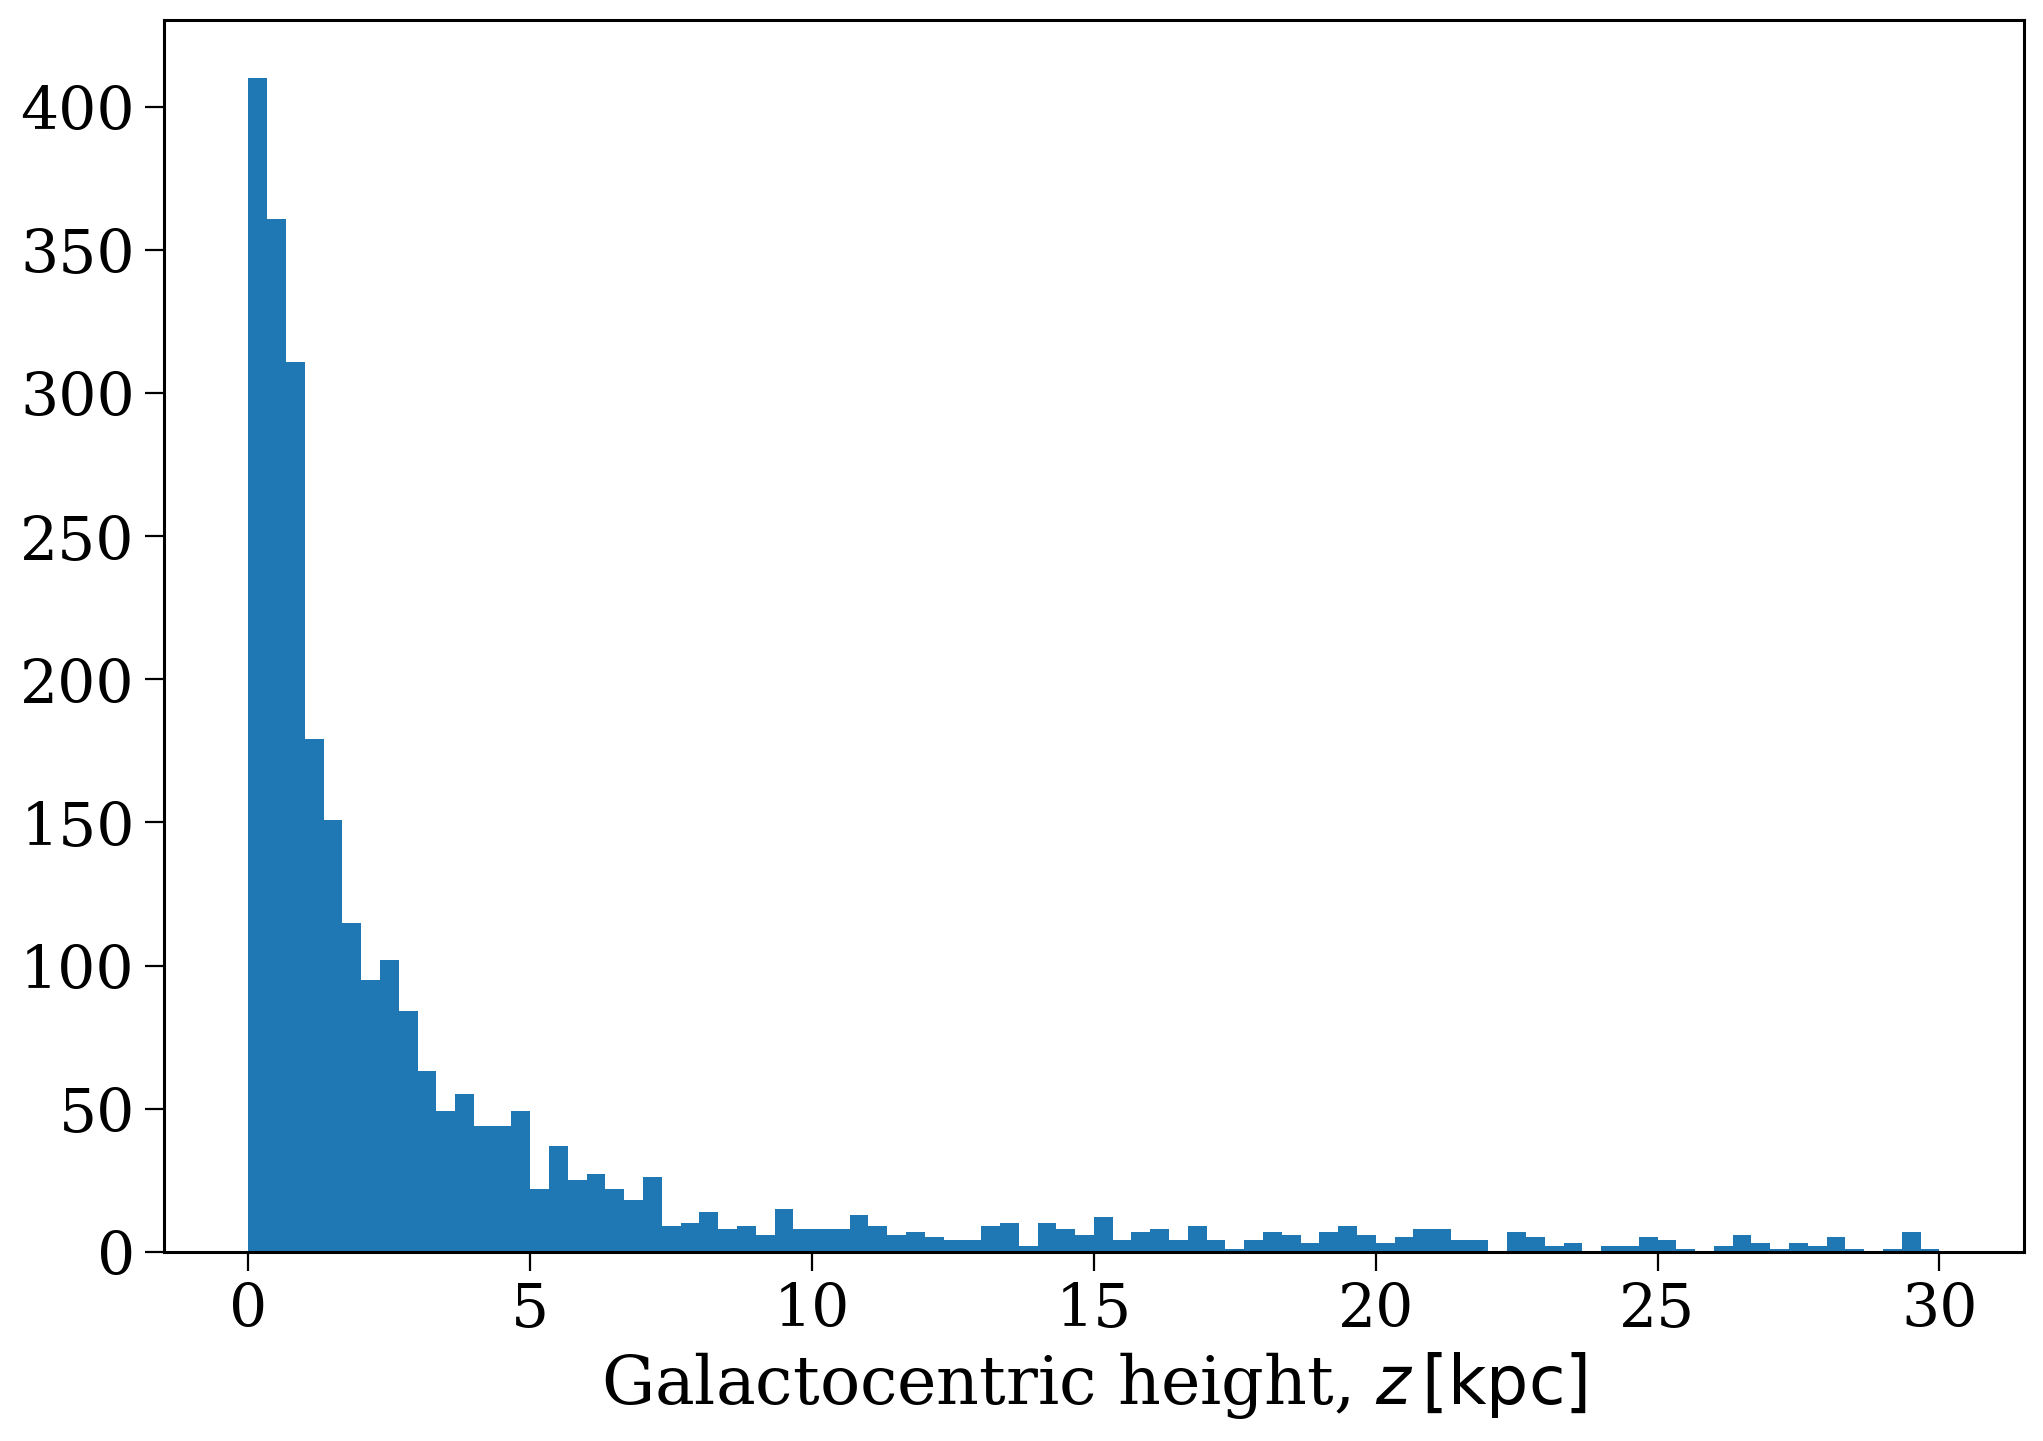

In [434]:
plt.hist(np.abs(final_pos[:, 2].value), bins=90, range=(0, 30));
plt.xlabel(r"Galactocentric height, $z \, {\rm [kpc]}$")
plt.show()

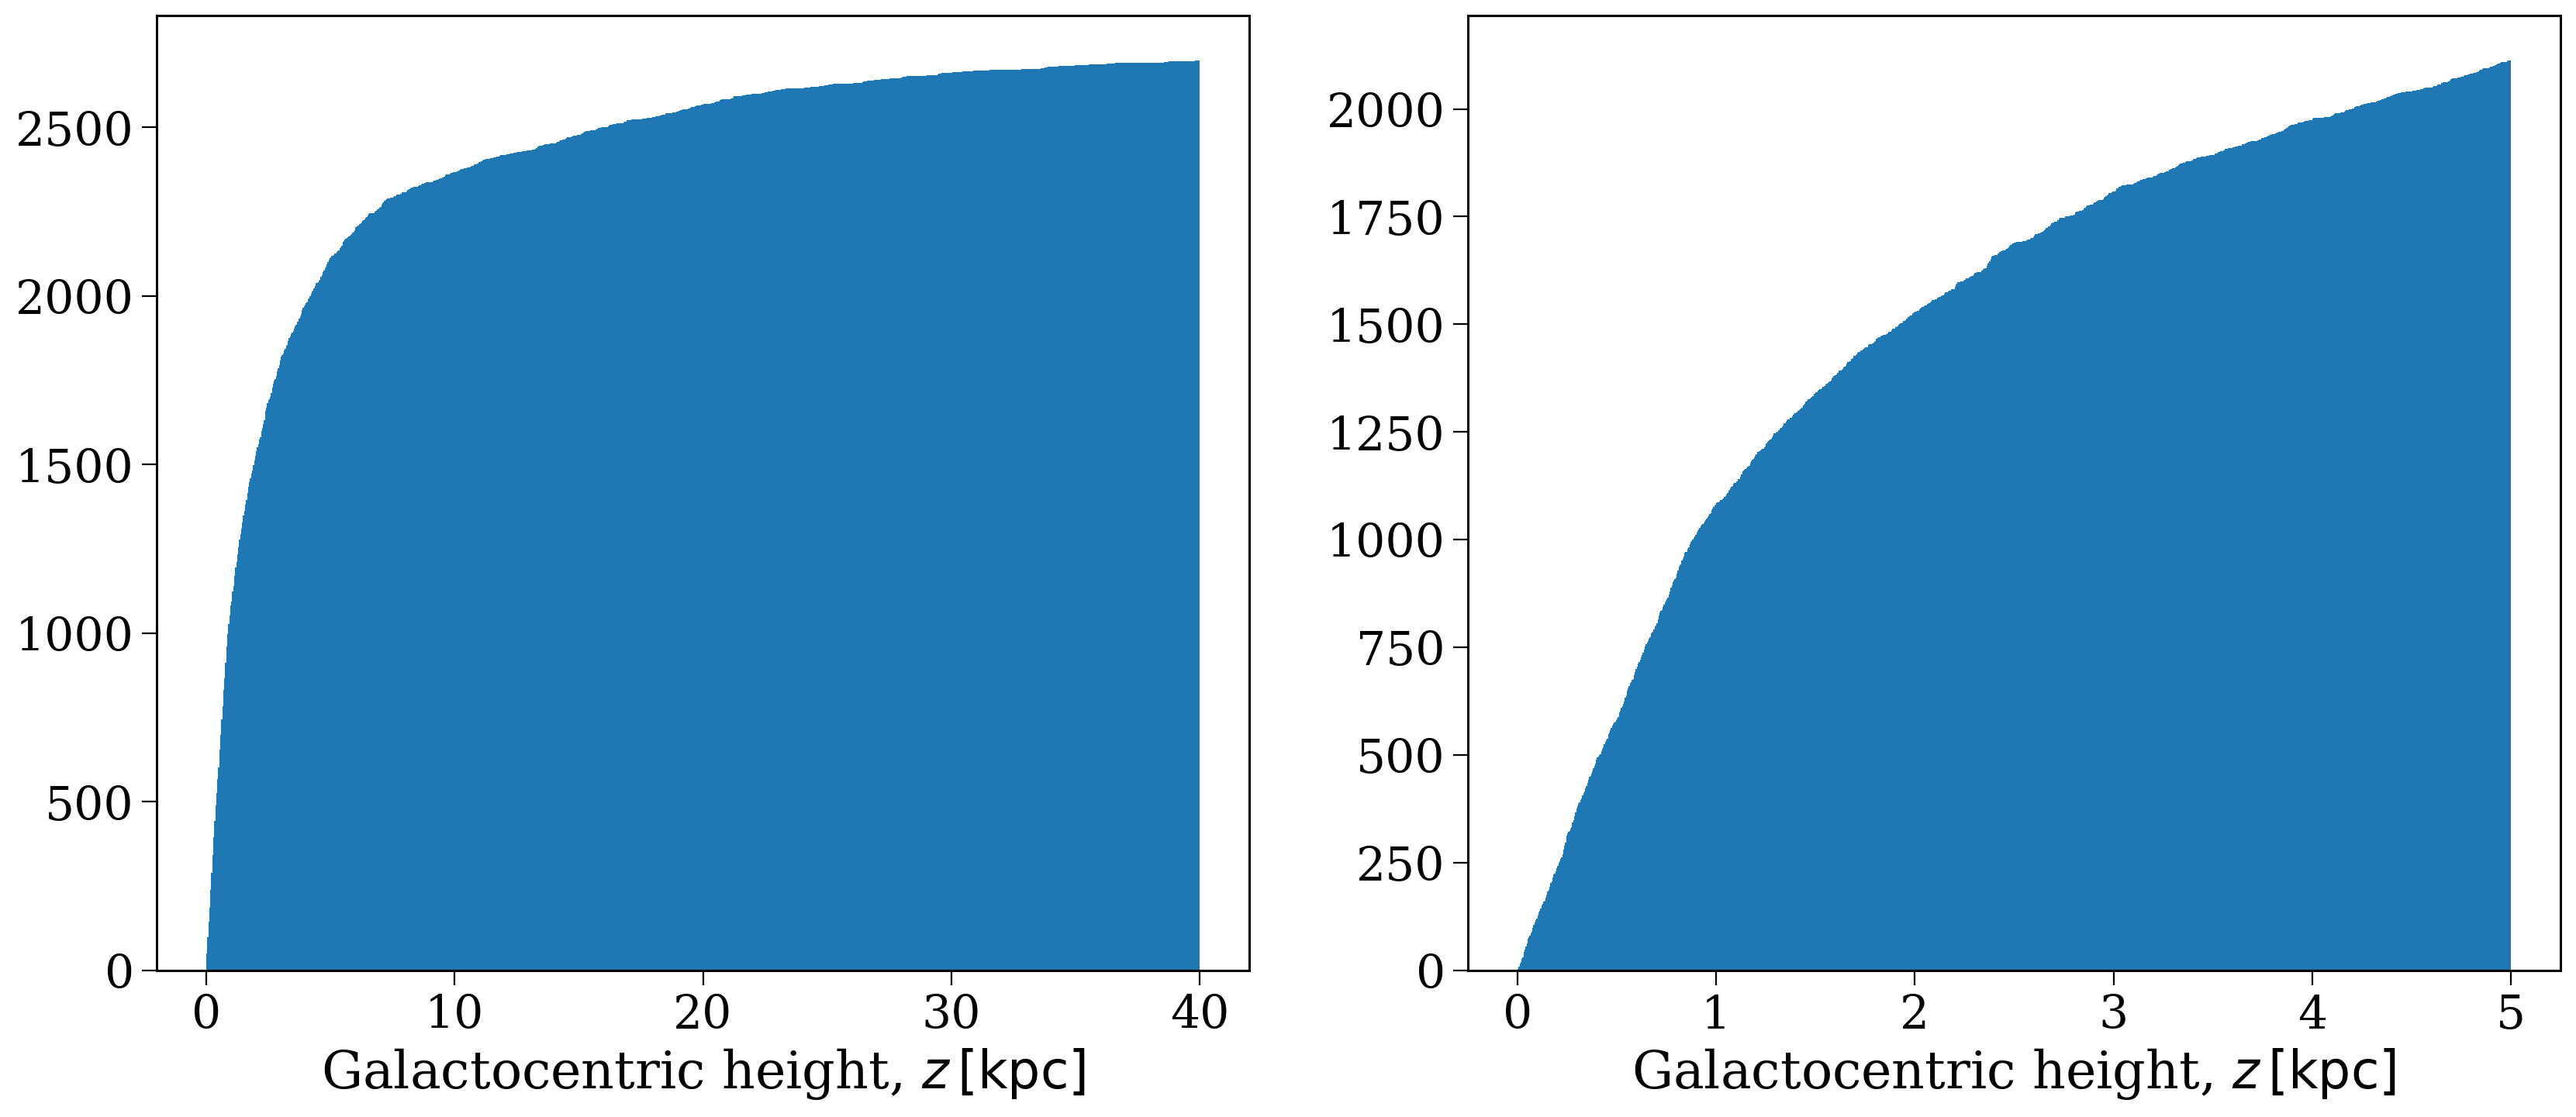

In [435]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for ax, lim in zip(axes, [40, 5]):
    ax.hist(np.abs(final_pos[:, 2].value), bins=1000, range=(0, lim), cumulative=True);
    ax.set_xlabel(r"Galactocentric height, $z \, {\rm [kpc]}$")
plt.show()

## X, Y clustering
You can see some of them actually trace their birth clusters quite well.

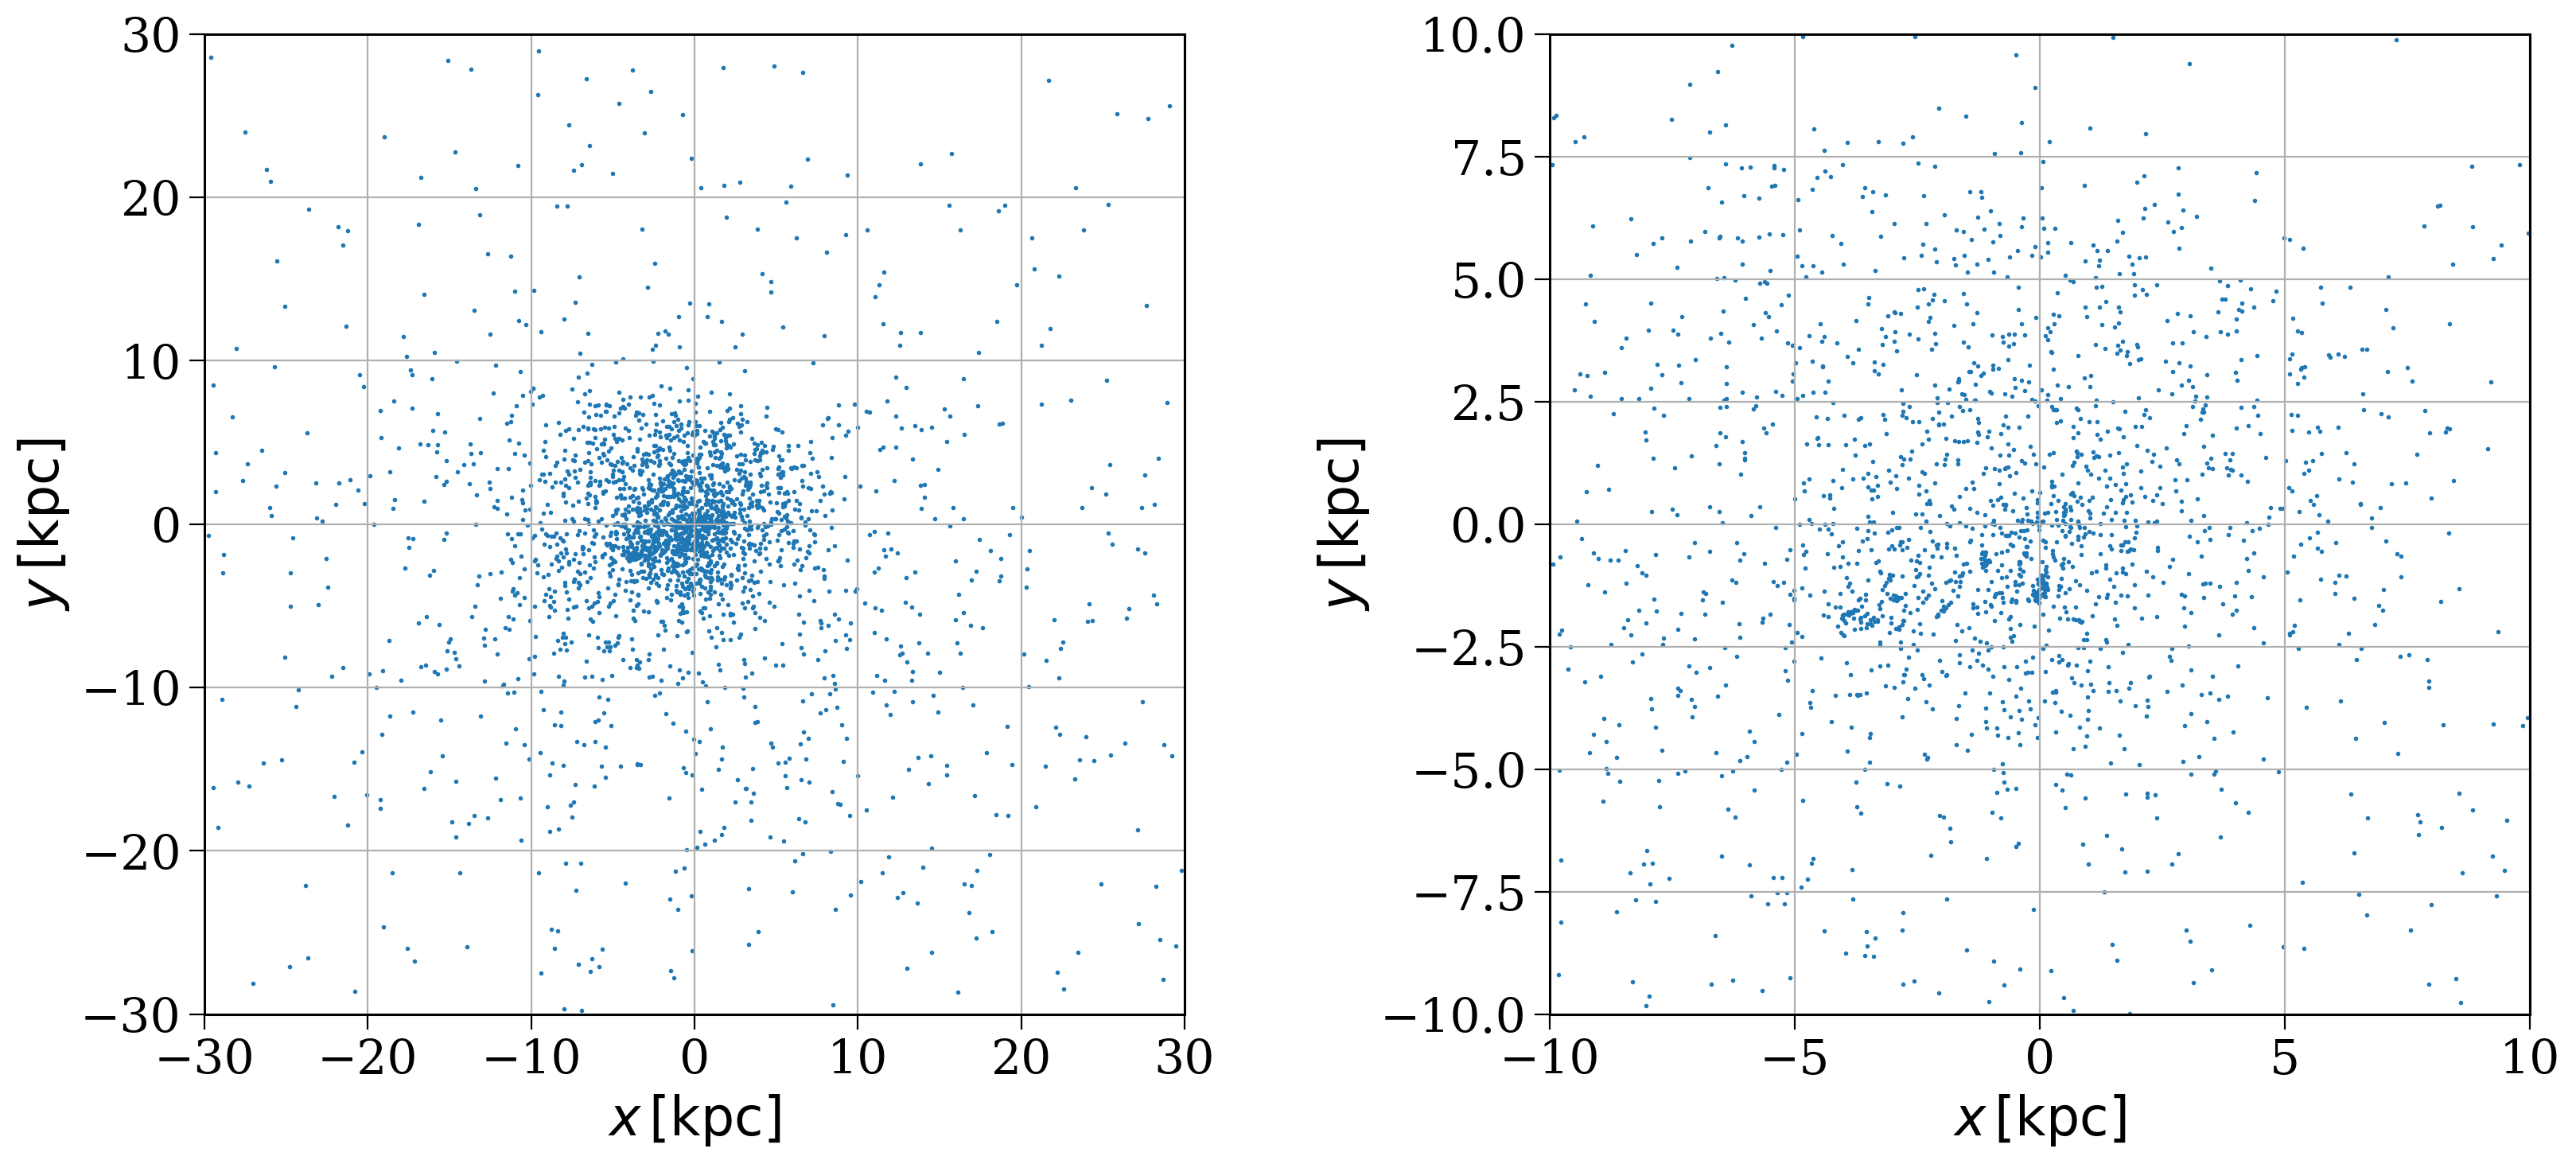

In [441]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for ax, lim in zip(axes, [30, 10]):
    scatter = ax.scatter(final_pos[:, 0], final_pos[:, 1], s=1)
    ax.set_aspect("equal")
    ax.set(xlim=(-lim, lim), ylim=(-lim, lim), xlabel=r"$x \, [\rm kpc]$", ylabel=r"$y \, [\rm kpc]$")
    ax.grid()
plt.show()

# Evolution

## Find SNs

In [442]:
retro_sn = np.unique(rp.bpp["bin_num"][rp.bpp["evol_type"].isin([15, 16])])
retro_sn

array([    555,     684,    1219, ..., 2155779, 2157415, 2160631])

In [443]:
len(retro_sn)

2577

!!?!? How is that less than 4000??

In [444]:
problems = rp.bin_nums[~np.isin(rp.bin_nums, retro_sn)]

In [446]:
rp.bpp.loc[125105]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num
125105,0.000000,4.115337,2.257351,1.0,1.0,7578.897590,30291.438014,0.723859,0.002729,0.002583,1.0,0.000000,0.000000,1.702997e+02,864.727026,0.000000,0.0,2.466048,1.774944,4.115337,2.257351,254.651451,24.565506,14748.754758,9688.547729,0.000000,0.0,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,5343.879139,7677.189027,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,125105
125105,170.425781,4.113087,2.257351,2.0,1.0,7581.573539,30312.832330,0.723859,0.006364,0.002836,2.0,170.537020,170.425781,1.705370e+02,864.727025,0.646172,0.0,5.752135,1.949237,4.113087,2.257351,699.261421,26.888421,12431.255136,9456.460632,0.142848,0.0,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1159.881319,6365.644667,0.0,0.0,0.0,0.0,0.0,0.0,-0.111239,9.935576e-09,0.0,0.0,125105
125105,171.217266,4.112796,2.257351,3.0,1.0,7581.919979,30315.602966,0.723859,0.038718,0.002837,2.0,171.359382,171.217263,1.705678e+02,864.727013,0.659346,0.0,34.995486,1.950152,4.112796,2.257351,364.757240,26.900130,4283.162776,9455.270963,0.145481,0.0,1.726764e+00,1.000000e-10,2.265278e+01,1.000000e-10,23.583631,6359.672981,0.0,0.0,0.0,0.0,0.0,0.0,-0.142116,2.403627e-06,0.0,0.0,125105
125105,171.875643,4.111329,2.257352,4.0,1.0,7583.661978,30329.542365,0.723859,0.108611,0.002837,2.0,172.017758,171.875510,1.705678e+02,864.726357,0.666142,0.0,98.183789,1.950914,4.112796,2.257352,1680.733672,26.909905,3746.488837,9454.281886,0.146825,0.0,3.445188e+00,1.000000e-10,9.803696e+01,1.000000e-10,2.994717,6354.719305,0.0,0.0,0.0,0.0,0.0,0.0,-0.142116,1.327627e-04,0.0,0.0,125105
125105,202.142822,4.062264,2.257367,5.0,1.0,7642.407423,30801.479308,0.723858,0.076507,0.002859,2.0,202.284938,202.139265,1.705678e+02,864.710124,0.912188,0.0,69.525835,1.987035,4.112796,2.257367,929.409002,27.365507,3839.266170,9407.359906,0.190627,0.0,3.150077e+00,1.000000e-10,6.933521e+01,1.000000e-10,5.913659,6126.170138,0.0,0.0,0.0,0.0,0.0,0.0,-0.142116,3.557709e-03,0.0,0.0,125105
125105,203.609442,4.014622,2.257630,6.0,1.0,7641.079220,30909.532527,0.721747,0.495381,0.002832,2.0,203.751558,203.537894,1.705678e+02,864.421216,0.849363,0.0,452.422763,1.988968,4.112796,2.257630,14389.890208,27.401011,2985.463440,9405.834818,0.048740,0.0,3.165260e+00,1.000000e-10,4.523740e+02,1.000000e-10,0.161400,6120.926091,0.0,0.0,0.0,0.0,0.0,0.0,-0.142116,7.154832e-02,0.0,0.0,125105
125105,204.158877,0.864108,2.556140,11.0,1.0,6257.829341,31022.653705,0.476412,0.000010,0.001370,2.0,0.000000,143.702858,1.705678e+02,608.449379,0.864108,0.0,0.009581,2.131375,0.864108,2.556140,30.435624,45.350071,139123.449000,10305.858168,0.009581,0.0,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,0.000006,10077.981645,0.0,0.0,0.0,0.0,0.0,0.0,204.158877,6.045602e+01,0.0,0.0,125105
125105,245.887759,0.864108,2.556140,11.0,1.0,6257.829343,31022.653727,0.476412,0.000010,0.001425,10.0,41.728882,185.431740,1.000000e+10,608.449379,0.864108,0.0,0.009581,2.216913,0.864108,2.556140,0.024549,46.966133,23445.788383,10193.925420,0.009581,0.0,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,0.000006,9315.279589,0.0,0.0,0.0,0.0,0.0,0.0,204.158877,6.045602e+01,0.0,0.0,125105


In [445]:
problems

array([ 125105,  125110,  125139,  125144,  125152,  126281,  232579,
        232589,  232594,  232595,  232599,  232609,  232662,  232692,
        234935,  235062,  235064,  235079,  235086,  235087,  235095,
        235121,  295919,  295937,  295958,  295961,  295980,  295991,
        295995,  296009,  522233,  522458,  615979,  651304,  651310,
        651324,  651355,  673484,  673487,  673534,  673556,  673693,
        673701,  673710,  673715,  673719,  673722,  673725,  673729,
        673733,  673739,  673758,  673774,  673892,  673901,  673908,
        673933,  673936,  673953,  673964,  673985,  694413,  694425,
        694460,  694491,  694501,  694525,  694528,  694537,  694544,
        966697,  966741,  966825,  966891,  967155,  967163,  967164,
        967168,  967191,  967194,  967210,  967213,  967220,  967247,
        967270, 1347536, 1347540, 1347582, 1347594, 1347725, 1347738,
       1347753, 1347755, 1347761, 1347775, 1673673, 1673684, 1673742,
       1673744, 1673

In [448]:
final_vel = mask_dis_1(rp.final_vel)

## Back-propagate orbits

In [286]:
from gala.dynamics import PhaseSpacePosition

In [289]:
wf = PhaseSpacePosition(pos=final_pos, vel=final_vel)

In [386]:
orbit = rp.galactic_potential.integrate_orbit(PhaseSpacePosition(pos=final_pos[2],
                                                                 vel=final_vel[2]),
                                              t1=246.993138 * u.Myr, t2=0.0 * u.Myr, dt=-0.1 * u.Myr)

In [449]:
orbit = rp.galactic_potential.integrate_orbit(PhaseSpacePosition(pos=final_pos[rp.bin_nums == 125105][0],
                                                                 vel=final_vel[rp.bin_nums == 125105][0]),
                                              t1=245.887759 * u.Myr, t2=0.0 * u.Myr, dt=-0.1 * u.Myr)

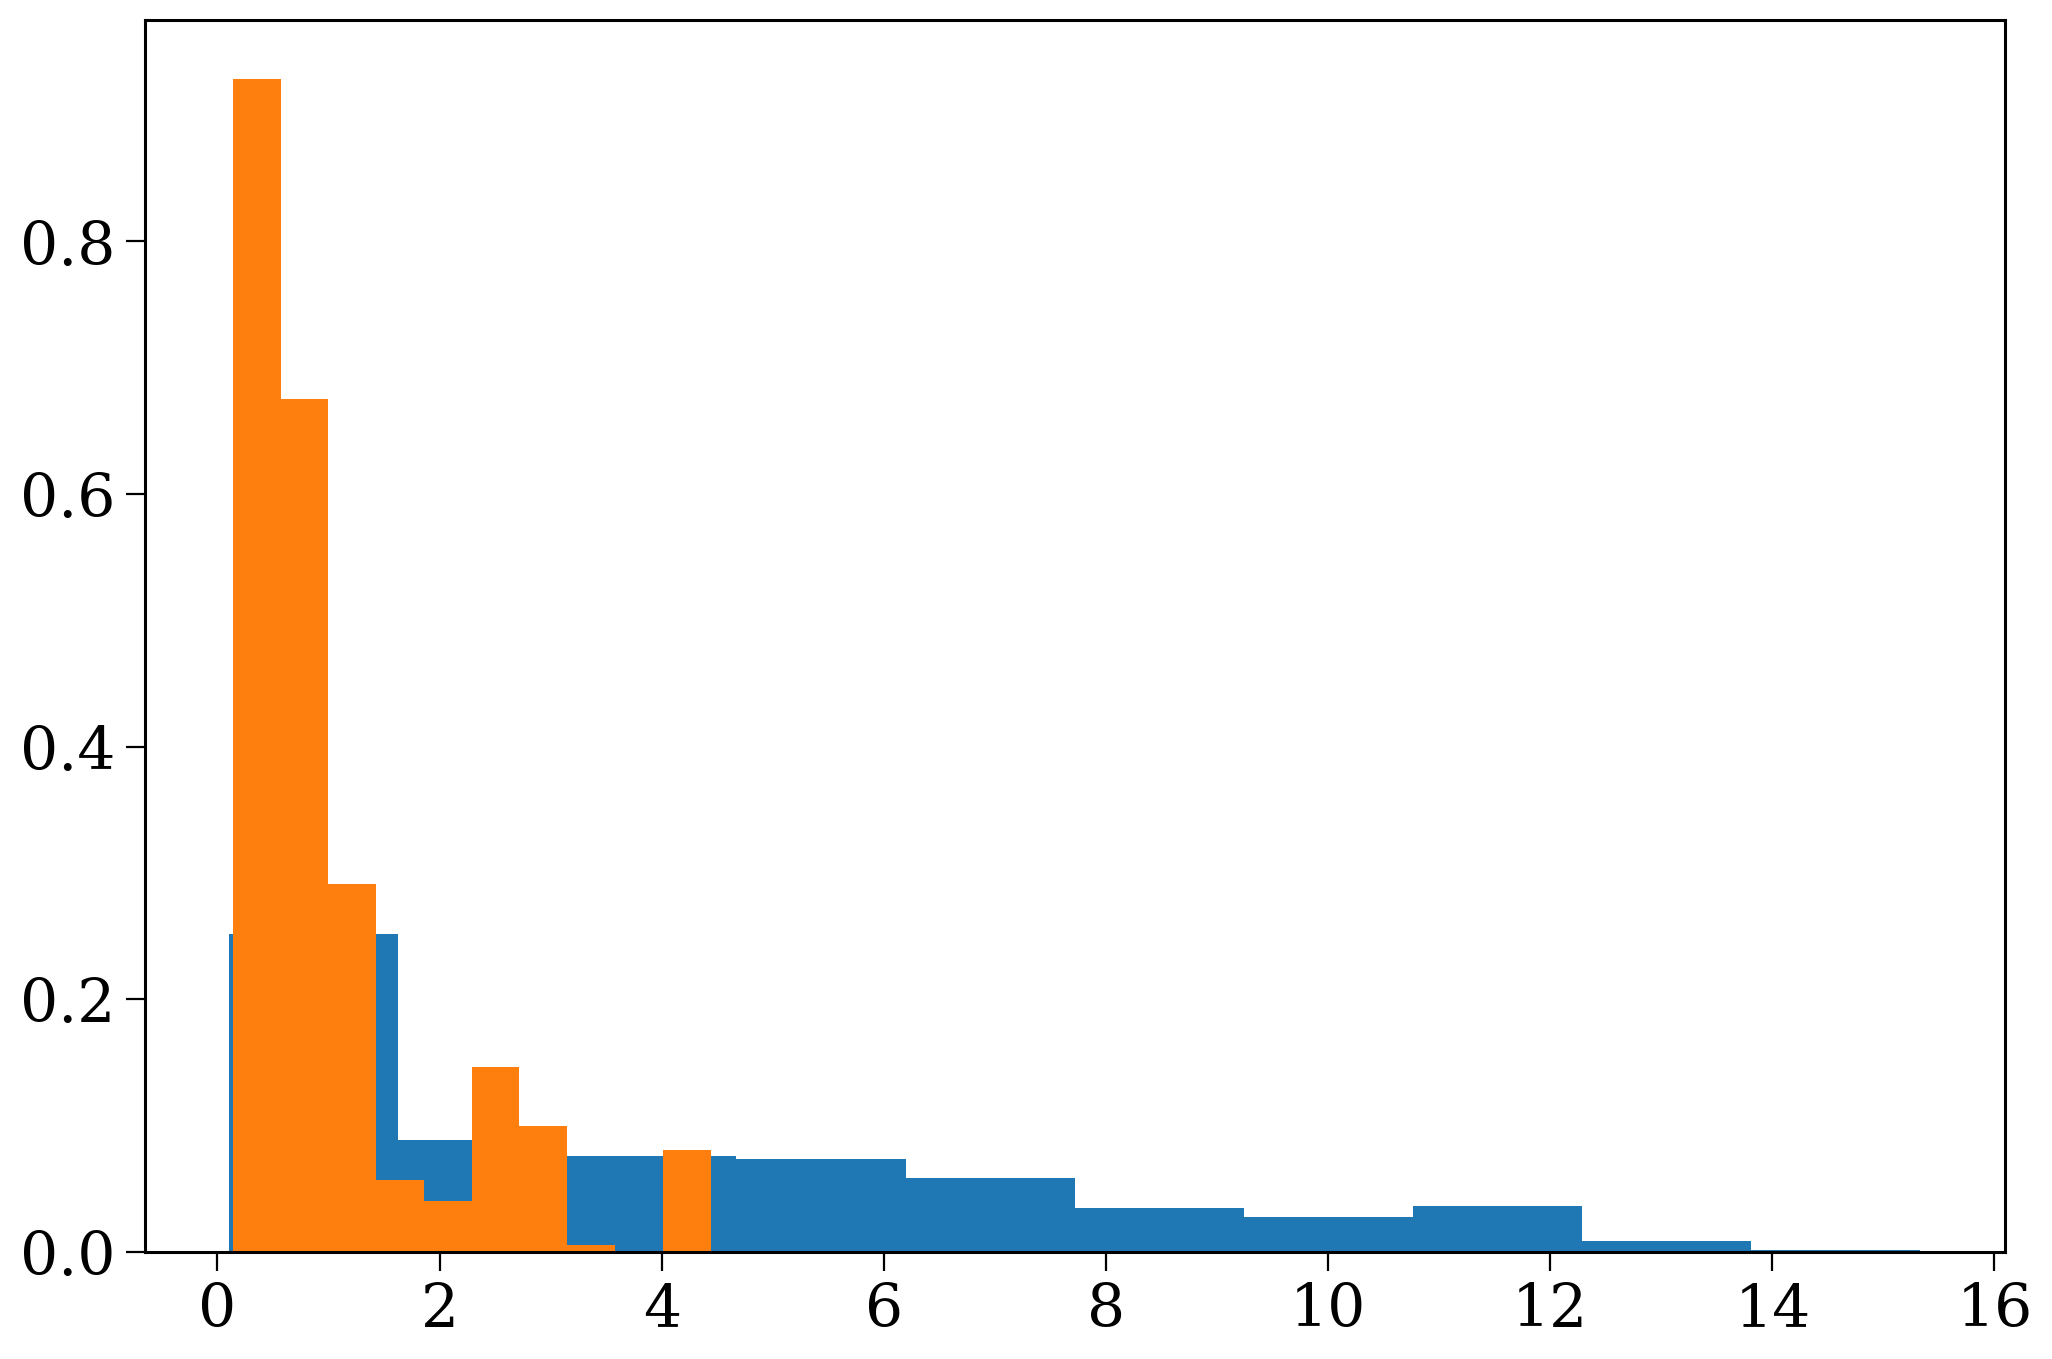

In [387]:
plt.hist(rp.initial_galaxy.rho, density=True)
plt.hist(rp.initial_galaxy.rho[np.isin(rp.bin_nums, problems)], density=True)
plt.show()

In [342]:
rp.initC.loc[problems]["particle_id"].value_counts()

particle_id
6473    47
8446    34
1319    31
6438    30
384     30
        ..
8203     1
8202     1
1041     1
4320     1
556      1
Name: count, Length: 102, dtype: int64

In [337]:
for i in range(orbit.shape[0]):
    test = vphi(orbit[i].pos.xyz[None, :], orbit[i].vel.d_xyz[None, :]) > 0
    if test:
        print(i)

In [294]:
rp.final_pos

<Quantity [[ -8.89397342,  -3.9723281 ,   7.18913689],
           [ -5.9170514 ,  -4.22458381, -10.71281617],
           [ -2.57348029,  -2.31347426,   0.23281249],
           ...,
           [  7.16979335,   0.82516534,  -3.00084873],
           [  7.00897638,  -1.33698447,  -0.11950419],
           [ 14.59984637, -10.49000384,   6.00448529]] kpc>

Maybe it's the star particles???

In [369]:
star_particles = pd.read_hdf("../data/FIRE_star_particles.h5")

In [391]:
np.sum(vphi(star_particles[["x", "y"]].values, star_particles[["v_x", "v_y"]].values) < 0)

65

HAH

In [392]:
weird_particles = vphi(star_particles[["x", "y"]].values, star_particles[["v_x", "v_y"]].values) < 0

In [393]:
star_particles[weird_particles]

,mass,Z,t_form,x,y,z,v_x,v_y,v_z
380,10397.042397,0.018770,13.694488,0.270750,0.609065,-0.219483,47.326710,45.557608,7.940832
383,10781.722612,0.019160,13.693751,0.268487,0.494910,-0.126479,42.515537,44.518849,18.145138
384,11395.025485,0.020168,13.694622,0.234606,0.703549,-0.244532,43.090705,48.823032,7.291918
388,10723.507280,0.018344,13.601719,-1.305563,-1.920995,0.790892,-0.636452,0.755994,-13.826853
391,9054.396295,0.017497,13.602387,-1.295886,-2.169635,0.841420,-0.864640,0.664303,-13.104743
...,...,...,...,...,...,...,...,...,...
8648,9306.167524,0.017479,13.619889,-0.198469,-1.198308,-0.171177,-4.141046,7.190898,-24.948082
8821,10011.026533,0.018390,13.682433,-0.210026,-0.234343,-0.106798,4.355784,8.399867,8.613599
8894,11936.295551,0.020460,13.723775,-1.257465,2.305843,1.160859,-17.656308,38.623599,20.203508
9030,9658.464570,0.017126,13.607997,-1.730475,-1.181285,0.425699,4.739948,4.352582,7.058974


In [396]:
wp_ids = star_particles[weird_particles].index.values

In [402]:
4035 / len(p)

0.0018671686504465935

In [414]:
rp_sn = rp[rp.bin_nums[~rp.initC["particle_id"].isin(wp_ids)]]

In [420]:
rp_sn

<Population - 2740 systems - galactic_potential=CompositePotential, SFH=Galaxy>

In [418]:
rp_sn.bpp["evol_type"].isin([15, 16]).sum()

2577